### Fits two lines to par0(x-par1) and par2(x-par3) with MInuit
### Adds a soft constraint on par1-par3

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.stats as stats
from iminuit import Minuit

In [2]:
# This is a nice utility to put a ROOT style stat box on a histogram plot
def statBox(ax, entries, binEdges, x=0.96, y=0.98, fontsize='medium'):
    """
    Put a stat box on the histogram at coord x and y
    font = medium is appropriate for 1x1.  Other choices are
    size in points, 'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'
    """
    en = len(entries)                   # number of entries
    ov = (entries>binEdges[-1]).sum()   # overflows
    uf = (entries<binEdges[0]).sum()    # underflows
    mn = entries.mean()                 # mean
    sd = entries.std()                  # standard deviation
    textstr = 'N=%i \nOverflow=%i \nUnderflow=%i \n$\mu=%.2f$ \n$\sigma=%.2f$' % (en, ov, uf, mn, sd)
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    ax.text(x, y, textstr,
            transform=ax.transAxes,
            bbox=props,
            fontsize=fontsize,
            horizontalalignment='right',
            verticalalignment='top'  ) 

In [3]:
class myFit:
    """
    Wrapper around a minuit chisq with a Gaussian constraint.
    y1fit = par[0]* (x1-par[1])
    y2fit = par[2]* (x2-par[3])
    chisq = (y1fit-y1meas)**2/s1**2 + (y2fit-y2meas)**2/s2**2 + (par[1]-par[2])**2/sigma**2
    Where sigma is something small enough to be an effective constraint
    
    Instantiate as 
    f = myFit(x1,x2,y1meas,y2meas,s1,s2,sigma=1e-4)
    (default sigma is 1 micron)
    
    Fit as (MINOS not needed for this)
    m = Minuit(f.CHI2, pinit, name=("p0","p1","p2","p3"))
    m.errordef = Minuit.CHISQUARED
    m.migrad()
    """
    
    def __init__(self,x1,x2,y1m,y2m,s1,s2,sigma=1e-4):
        self.x1  = x1
        self.x2  = x2
        self.y1m = y1m
        self.y2m = y2m
        self.s1  = s1
        self.s2  = s2
        self.s   = sigma
        
    def CHI2(self, par):
        y1fit = par[0]* (self.x1-par[1])
        y2fit = par[2]* (self.x2-par[3])
        t1    = ( (y1fit-self.y1m)**2/(self.s1*self.s1) ).sum()
        t2    = ( (y2fit-self.y2m)**2/(self.s2*self.s2) ).sum()
        t3    = (par[1]-par[3])**2/(self.s*self.s)
        return t1+t2+t3

In [4]:
# --------------------------------
# Here are the needed constants
#---------------------------------
nDetectors = 4
w          = 0.005  # 50 micron is strip width
s          = np.full(nDetectors, w/np.math.sqrt(12))  # resolution in each hit
xdet       = np.array([2., 3., 5., 7.]) # x coordinates of detectors

In [5]:
# read all data into numpy arrays
data = np.loadtxt("straightTracks.txt")
xv   = data[:,0]   # true xverteces (called X0 in the exercise pdf)
yv   = data[:,1]   # true yverteces
nev  = len(xv)     # number of pairs of tracks
trk1 = data[:,[2,3,4,5]]   # hits for track number 1
trk2 = data[:,[6,7,8,9]]   # hits for track number 2

In [6]:
# Now do the constrained fit (store results in arrays)
fitVertex1 = np.empty(nev)  
fitVertex2 = np.empty(nev)  
pull1      = np.empty(nev)
pull2      = np.empty(nev)
chiProb    = np.empty(nev)
x1d   = xdet.copy()  # not sure if the copy is necessary, but it can't hurt
x2d   = xdet.copy()
s1d   = s.copy()
s2d   = s.copy()
igood = 0
for i in range(nev):  # loop over pairs
    y1 = trk1[i][:]   # coordinates of trk 1 for this pair
    y2 = trk2[i][:]   # coordinates of trk 2 for this pair

    # guess parameters
    slope1 = ( y1[3] - y1[0] ) / ( x1d[3] - x1d[0] )
    slope2 = ( y2[3] - y2[0] ) / ( x2d[3] - x2d[0] )
    inter1 = y1[3] - slope1 * x1d[3]
    inter2 = y2[3] - slope2 * x2d[3]
    guess = np.array( [slope1, inter1, slope2, inter2] )

    # Now minuit
    f = myFit(x1d,x2d,y1,y2,s1d,s2d,sigma=1e-4)
    m = Minuit(f.CHI2, guess, name=("p0","p1","p2","p3"))
    m.errordef = 1.
    m.migrad()
    
    if m.valid:    # fit worked
    
        # The fitted vertex in microns and the pull 
        thisFitVertex1     = 10000*m.values['p1']
        thisPull1          = (m.values['p1']-xv[i])/m.errors['p1']
        fitVertex1[igood]  = thisFitVertex1
        pull1[igood]       = thisPull1
        thisFitVertex2     = 10000*m.values['p3']
        thisPull2          = (m.values['p3']-xv[i])/m.errors['p3']
        fitVertex2[igood]  = thisFitVertex2
        pull2[igood]       = thisPull2
    
        # chiprob is like TMath::Prob in ROOT.
        # Probability that an observed Chi-squared exceeds
        # the value chisq by chance, even for a correct model
        ndof  = len(y1) + len(y2) - (len(guess)-1)
        chisq = m.fval
        thisChiProb     = 1. - stats.chi2.cdf(chisq, ndof)
        chiProb[igood]  = thisChiProb
    
        igood = igood+1
        
    else:
        
        print("Fit on event ",i," failed")
    


In [7]:
# If some fits failed, take them out from the list
if igood != nev:
    fitVertex1 = fitVertex1[0:igood]
    fitVertex2 = fitVertex2[0:igood]
    pull1      = pull1[0:igood]
    pull2      = pull2[0:igood]
    chiprob    = chiprob[0:igood]

In [8]:
# Sanity check: They need to be about the same
np.testing.assert_allclose(fitVertex1, fitVertex2, rtol=0.01, atol=1)
np.testing.assert_allclose(pull1,          pull2, rtol=1, atol=0.01)

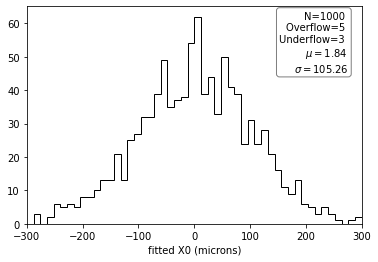

In [9]:
# Plot the fitted value
ax33 = plt.subplot(111)
con33, bins33, _ = ax33.hist(fitVertex1, np.linspace(-300.,300.,51), histtype='step', color='black')
statBox(ax33, fitVertex1, bins33)
ax33.set_xlim(bins33[0], bins33[-1])
_ = ax33.set_xlabel("fitted X0 (microns)")

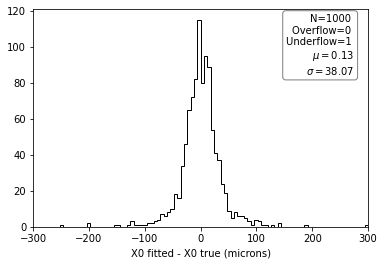

In [10]:
# Plot the difference between the fitted and true vertex
ax3 = plt.subplot(111)
dxfit = fitVertex1 - 10000*xv
con3, bins3, _ = ax3.hist(dxfit, np.linspace(-300.,300.,101), histtype='step', color='black')
statBox(ax3, dxfit, bins3)
ax3.set_xlim(bins3[0], bins3[-1])
_ = ax3.set_xlabel("X0 fitted - X0 true (microns)")

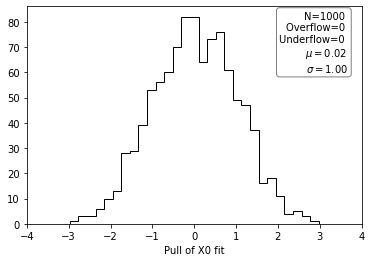

In [11]:
# Plot the pull
ax4 = plt.subplot(111)
con4, bins4, _ = ax4.hist(pull1, np.linspace(-4.,4.,40), histtype='step', color='black')
statBox(ax4, pull1, bins3)
ax4.set_xlim(bins4[0], bins4[-1])
_ = ax4.set_xlabel("Pull of X0 fit")

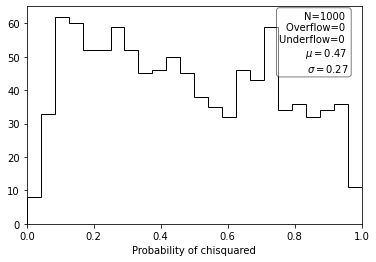

In [12]:
# Plot the chisquared probability 
probAx = plt.subplot(111)
probContents, probBins, _ = probAx.hist(chiProb, np.linspace(0.,1.,25), histtype='step', color='black')
statBox(probAx, chiProb, probBins)
probAx.set_xlim(probBins[0], probBins[-1])
_ = probAx.set_xlabel("Probability of chisquared")